In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [11]:
data = pd.read_csv("../Results/upset_probs.csv")

In [12]:
# If odds1 is 1.28 & odds2 is 3.50
# $1 on P1 would give a profit $ on 0.28 his win
# p1*(0.28) + (1-p1)*(-1) = 0 => 1.28*p1 = 1 => p1 = 1.0/1.28 = 0.78
# $1 on P2 would give a profit $ on 2.50 his win
# p2 = 1.0/3.5 = 0.29
# p1 + p2 = 0.97         # The gap if their cut

data["prob-diff1"] = data["Predicted prob"]-(1.0/data["Odds1"])
data["prob-diff2"] = (1.0-data["Predicted prob"])-1.0/data["Odds2"]

X = data[["prob-diff1","prob-diff2","Odds1","Odds2"]]
y = data[["Result"]]

In [13]:
# Idea :
# Map the match features i.e. win probs, betting odds, variance to the bet to be placed (as a fraction of available $)

# Match State : prob_diff1, prob_diff2
# Action : Place say -20% of the $ in hand (-ve indicates against player1 or on player2)

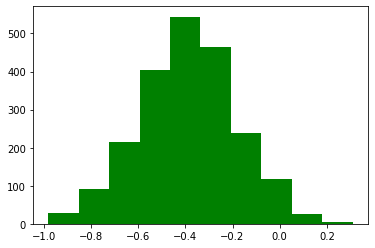

In [34]:
plt.hist(data["prob-diff1"],color='green')
plt.show()

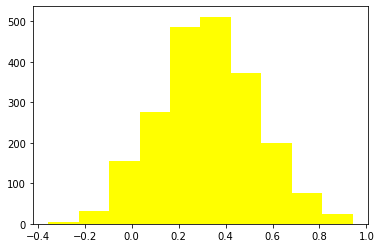

In [33]:
plt.hist(data["prob-diff2"],color='yellow')
plt.show()

In [18]:
X_train = np.array(X[:1800])
X_test = np.array(X[1800:])

y_train = np.array(y[:1800])
y_test = np.array(y[1800:])

## Training Loop

In [19]:
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def grad_tanh(z):
    a = tanh(z)
    return 1-a**2

n_epochs = 25
lr = 1e-3

# Initialize weights & biases
W = 0.01*np.random.randn(4)
b = 0.01*np.random.randn(1)

for epoch in range(n_epochs):
    train_loss = 0.0
    #print(train_loss,W,b)
    for i in range(X_train.shape[0]):
        z = np.dot(X_train[i],W)+b
        bet = tanh(z)
        result = y_train[i]
        # gradient of W,b w.r.t bet
        grad_W = np.transpose(X_train[i])*grad_tanh(z)
        grad_b = np.ones_like(b)*grad_tanh(z)

        loss = 0.0
        if(bet > 0):
            loss = bet
            if(result<1e-6):
                loss -= X_train[i,2]*bet
                grad_W *= (1-X_train[i,2])
                grad_b *= (1-X_train[i,2])
        else:
            bet *= -1
            grad_W *= -1
            grad_b *= -1
            loss = bet
            if(result>1e-6):
                loss -= X_train[i,3]*bet
                grad_W *= (1-X_train[i,3])
                grad_b *= (1-X_train[i,3])

        W -= lr*grad_W
        b -= lr*grad_b
        train_loss += loss

    train_loss /= (X_train.shape[0])
    print("Epoch",epoch+1,":",train_loss[0])


Epoch 1 : 0.004269435683650262
Epoch 2 : 0.005022898644017949
Epoch 3 : 0.003565436092263262
Epoch 4 : 0.003725639585024525
Epoch 5 : 0.00392549894141202
Epoch 6 : 0.0037221820039732216
Epoch 7 : 0.0038634669060006186
Epoch 8 : 0.00394814101936743
Epoch 9 : 0.003958179546744464
Epoch 10 : 0.004016671406550838
Epoch 11 : 0.004162852641256668
Epoch 12 : 0.0041188601470770626
Epoch 13 : 0.004080015388583089
Epoch 14 : 0.0044819531573916955
Epoch 15 : 0.004222102854776587
Epoch 16 : 0.004196370077040707
Epoch 17 : 0.004207675158060632
Epoch 18 : 0.004428911988925873
Epoch 19 : 0.004414948114509783
Epoch 20 : 0.004391073523582042
Epoch 21 : 0.004354865821166133
Epoch 22 : 0.004347445637820982
Epoch 23 : 0.00431656983567143
Epoch 24 : 0.004349932427357782
Epoch 25 : 0.004304765235476661


## Testing set : Results

In [20]:
test_loss = 0.0
for i in range(X_test.shape[0]):
    z = np.dot(X_test[i],W)+b
    bet = tanh(z)
    result = y_test[i]

    loss = 0.0
    if(bet > 0):
        loss = bet
        if(result<1e-6):
            loss -= X_train[i,2]*bet
    else:
        bet *= -1
        loss = bet
        if(result>1e-6):
            loss -= X_train[i,3]*bet

    test_loss += loss

test_loss /= (X_train.shape[0])
print("Test loss: ",test_loss[0])

Test loss:  -0.029272947930299303


In [176]:
# Output : Test loss of -0.03 indiating $0.03 profits per $ bet on the test set on an average

## Rolland Garros 2021 : Betting results

In [67]:
RG_data = pd.read_csv("../Results/RG-2021_upset_probs.csv")
RG_metadata = pd.read_csv("../Results/RG-2021_metadata.csv")

In [68]:
RG_data["prob-diff1"] = RG_data["Predicted prob"]-(1.0/RG_data["Odds1"])
RG_data["prob-diff2"] = (1.0-RG_data["Predicted prob"])-1.0/RG_data["Odds2"]

X = RG_data[["prob-diff1","prob-diff2","Odds1","Odds2"]]
y = RG_data[["Result"]]

In [69]:
bets = []
for i in range(X.shape[0]):
    z = np.dot(X_train[i],W)+b
    bet = tanh(z)
    bets.append(bet[0])

In [70]:
final_data = RG_metadata.copy(deep=True)
final_data["bets1"] = np.maximum(0.0,np.array(bets))
final_data["bets2"] = np.maximum(0.0,-np.array(bets))
final_data["odds1"] = X["Odds1"]
final_data["odds2"] = X["Odds2"]
final_data["Result"] = y

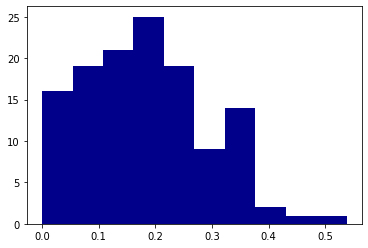

In [71]:
plt.hist(final_data["bets2"],color='darkblue')
plt.show()

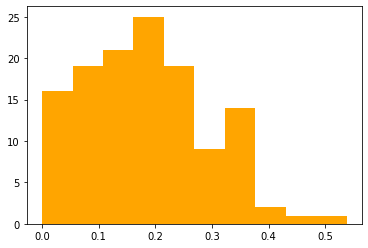

In [72]:
plt.hist(final_data["bets2"],color="orange")
plt.show()

In [83]:
moneyInHand = 1.0                      # Start with $1
moneyInHandDistro = []

for i in range(92):
    result = final_data.loc[i]["Result"]
    bet1 = final_data.loc[i]["bets1"]
    odds1 = final_data.loc[i]["odds1"]
    if(result < 0.5):
        moneyInHand += bet1*(odds1-1)*moneyInHand
    else:
        moneyInHand -= bet1*moneyInHand
    bet2 = final_data.loc[i]["bets2"]
    odds2 = final_data.loc[i]["odds2"]
    if(result > 0.5):
        moneyInHand += bet2*(odds2-1)*moneyInHand
    else:
        moneyInHand -= bet2*moneyInHand

    moneyInHandDistro.append(moneyInHand)


### Money in hand throughout the tournament

Text(0, 0.5, '$ in hand')

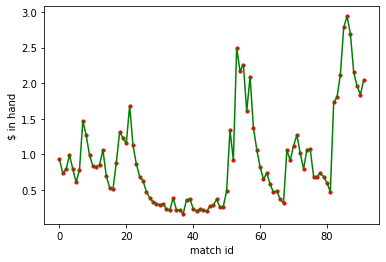

In [117]:
plt.plot(moneyInHandDistro,color='g')
plt.scatter(np.arange(92),moneyInHandDistro,s=10,c='r')
plt.xlabel("match id")
plt.ylabel("$ in hand")

### Matchwise : Betting results

In [111]:
for i in range(final_data.shape[0]):
    p1 = final_data.loc[i]["Name1"]
    p2 = final_data.loc[i]["Name2"]
    bet = final_data.loc[i]["bets1"] + final_data.loc[i]["bets2"]
    result = final_data.loc[i]["Result"]
    verdict = ""
    if(result==0.0):
        verdict = "won"
    else:
        verdict = "lost"
    print(p1,'v/s',p2,"\nBet % of moneyInHand:", bet.round(2), " Verdict:",verdict,"\n\n")

Fognini F. v/s Barrere G. 
Bet % of moneyInHand: 0.07  Verdict: won 


Carreno Busta P. v/s Gombos N. 
Bet % of moneyInHand: 0.21  Verdict: won 


Gerasimov E. v/s Couacaud E. 
Bet % of moneyInHand: 0.11  Verdict: lost 


Hanfmann Y. v/s Laaksonen H. 
Bet % of moneyInHand: 0.23  Verdict: lost 


Bautista Agut R. v/s Vilella Martinez M. 
Bet % of moneyInHand: 0.2  Verdict: won 


Pella G. v/s Galan D. 
Bet % of moneyInHand: 0.24  Verdict: won 


Evans D. v/s Kecmanovic M. 
Bet % of moneyInHand: 0.19  Verdict: lost 


Thiem D. v/s Andujar P. 
Bet % of moneyInHand: 0.15  Verdict: lost 


Khachanov K. v/s Vesely J. 
Bet % of moneyInHand: 0.14  Verdict: won 


Fucsovics M. v/s Simon G. 
Bet % of moneyInHand: 0.22  Verdict: won 


Nishikori K. v/s Giannessi A. 
Bet % of moneyInHand: 0.15  Verdict: won 


Garin C. v/s Londero J.I. 
Bet % of moneyInHand: 0.01  Verdict: won 


Ruusuvuori E. v/s Mcdonald M. 
Bet % of moneyInHand: 0.11  Verdict: lost 


Dimitrov G. v/s Giron M. 
Bet % of moneyInH

In [116]:
print("Rolland Garros 2021 - Money Multiplier:",moneyInHand.round(2))

Rolland Garros 2021 - Money Multiplier: 2.05
